In [1]:
import sys
#sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom_fork') # ut.py etc. (github)
sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master') # 

import matplotlib
#matplotlib.use('Agg') #-- use in batch mode
matplotlib.use('TkAgg')
from netCDF4 import Dataset, MFDataset
import pyfesom as pf
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import cm
from colorbars import cmap_correlations256
import seawater as sw
import pandas as pd
from collections import OrderedDict

In [2]:
%matplotlib inline
%load_ext ipycache

/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


#### first, define some functions for loading and plotting of the data (re-used for all the grids!)

In [3]:
def load_andcompute_TSRho_split(firstyear, lastyear, mesh, filetmp):
    "Load and compute mean T, S, and density (sigma1) for the period (firstyear---lastyear). Split the computation in parts if you encounter memory errors."
    
    ## load the files into one dataset
    #files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    #fl = MFDataset(files)
    #
    #print 'Computing mean ...'
    #temp = fl.variables['temp'][:,:].mean(axis=0) # 1x 3D field
    #salt = fl.variables['salt'][:,:].mean(axis=0) # 1x 3D field
    #print 'Done.'
    
    # load the files into one dataset
    files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
    fl = MFDataset(files)

    # initialize
    dim3D=np.shape(fl.variables['temp'][0,:])[0]
    temp=np.zeros(dim3D)
    salt=np.zeros(dim3D)

    print 'Computing mean ...'
    temp[0:dim3D/2] = fl.variables['temp'][:,0:dim3D/2].mean(axis=0) # 1x 3D field
    temp[dim3D/2:] = fl.variables['temp'][:,dim3D/2:].mean(axis=0) # 1x 3D field
    salt[0:dim3D/2] = fl.variables['salt'][:,0:dim3D/2].mean(axis=0) # 1x 3D field
    salt[dim3D/2:] = fl.variables['salt'][:,dim3D/2:].mean(axis=0) # 1x 3D field
    print 'Done.'

    # load climatology
    climpath='/mnt/lustre01/work/bm0944/a270046/DATA/climatology/'
    clim = pf.climatology(climpath, climname='phc') # climname='phc'|'woa05'
    
    # map fesom data to PHC climatology grid
    xx,yy,zz_temp_pot = pf.fesom2clim(temp, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=300000)
    xx,yy,zz_salt = pf.fesom2clim(salt, mesh, clim, verbose=False, how='idist', k_neighbors=10, radius_of_influence=300000)

    # initialize additional variables
    zz_temp_insitu=np.copy(zz_temp_pot)

    zz_sigma_1=np.zeros_like(zz_temp_pot)
    PHC_temp_insitu=np.zeros_like(zz_temp_pot)
    PHC_sigma_1=np.zeros_like(zz_temp_pot)

    # for every layer (0 ... 32):
    for ilevel in np.arange(np.shape(clim.z)[0]):
    
       # FESOM PART
       # calculates temperature from potential temperature at the reference pressure PR and in situ pressure P
       zz_temp_insitu[ilevel,:,:]=sw.eos80.temp(zz_salt[ilevel,:,:], zz_temp_pot[ilevel,:,:], clim.z[ilevel], pr=0)
    
       # density of Sea Water using UNESCO 1983 (EOS 80) polynomial
       zz_sigma_1[ilevel,:,:]=sw.eos80.pden(zz_salt[ilevel,:,:], zz_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
       # PHC PART (pot. 'clim' values are loaded in newest version of pyfesom)
       PHC_temp_insitu[ilevel,:,:]=sw.eos80.temp(clim.S[ilevel,:,:], clim.T[ilevel,:,:], clim.z[ilevel], pr=0)
       PHC_sigma_1[ilevel,:,:]=sw.eos80.pden(clim.S[ilevel,:,:], PHC_temp_insitu[ilevel,:,:], clim.z[ilevel], pr=1000.)-1000.
    
    return xx,yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1

In [4]:
zz=OrderedDict()
for sim in ['REF','LR','MR0','MR','HR']:
    zz[sim]=OrderedDict()

In [5]:
zz['PHC']=OrderedDict()

### CORE2 (30 years at end)

In [6]:
# config
meshname4plots ='LR'
meshpath  ='/work/bm0944/input/CORE2_final/' # COREII at DKRZ

# original data
#filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.mean.nc' # COREII data at DKRZ
#filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output/fesom.{}.oce.diag.nc' # COREII data at DKRZ
# annual means
filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # annual COREII data at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output/cdo-postprocessing/fesom.{}.oce.annualdiagMLD.nc' # annual COREII data at DKRZ

firstyear=2078 # 30yr period at the end (71--100)
lastyear=2107

# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

# load data and compute density for above period
xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
## load and remap mixed layer for above period
#xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
#                                                                lastyear=lastyear, \
#                                                                mesh=mesh, \
#                                                                filetmp=filedia)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/joblib_mesh
Computing mean ...
Done.


/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:83: RuntimeWarning: invalid value encountered in greater
  self.T = np.copy(ncfile.variables['temp'][:,:,:])
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:92: RuntimeWarning: invalid value encountered in greater
  self.S=np.copy(ncfile.variables['salt'][:,:,:])
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:100: RuntimeWarning: Mean of empty slice
  self.Tyz=nanmean(self.T, 2)
/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom-master/pyfesom/climatology.py:101: RuntimeWarning: Mean of empty slice
  self.Syz=nanmean(self.S, 2)


In [7]:
zz['LR']['temp_pot']=zz_temp_pot
zz['LR']['zz_salt']=zz_salt
zz['LR']['sigma_1']=zz_sigma_1

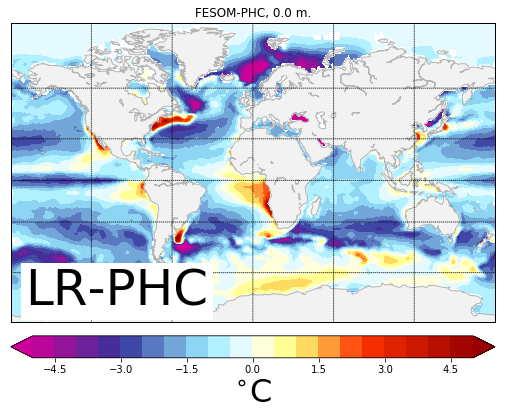

In [8]:
#########################################################################################
#				   SURFACE   TEMPERATURE					#
#########################################################################################
# change it to get results on different layers.
nlevel = 0

# plot FESOM data, PHC data, and differences
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
x,y = m(xx,yy) # coordinates for target grid

fig=plt.figure(figsize=(14,7))

plt.subplot(122)
m.drawmapboundary(fill_color='white')
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.7', antialiased=1)
m.fillcontinents(color='0.95')

levels = np.arange(-5., 5.5, 0.5)
plt.contourf(x, y, zz['LR']['temp_pot'][nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
plt.annotate(meshname4plots+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=50)
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
cbar.set_label("$^{\circ}$C", fontsize=32)
plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
plt.tight_layout()
plt.show()

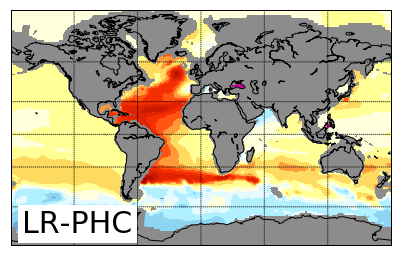

In [9]:
fig=plt.figure(figsize=(15,30))

plt.subplot(522)

#########################################################################################
#				   1000m   TEMPERATURE					#
#########################################################################################
# change it to get results on different layers.
nlevel = 18

# plot FESOM data, PHC data, and differences
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
x,y = m(xx,yy) # coordinates for target grid

#fig=plt.figure(figsize=(14,7))

#plt.subplot(122)
m.drawmapboundary(fill_color='0.55')
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
m.fillcontinents(color='0.55')

levels = np.arange(-5., 5.5, 0.5)
plt.contourf(x, y, zz['LR']['temp_pot'][nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
plt.annotate(meshname4plots+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
#cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
#cbar.set_label("$^{\circ}$C", fontsize=32)
#plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
#plt.tight_layout()
plt.show()

## load REF

In [10]:
# config
meshname4plots ='REF'
meshpath  ='/work/bm0944/input/mesh_ref87k/' # REF at DKRZ

filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_ref87k/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # REF at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output_ref87k/cdo-postprocessing/fesom.{}.oce.diag.nc' # REF at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

# 30yr period at the end (year 71--100)
firstyear=1921 # 1859 is year 9
lastyear=1950 

# load data and compute density for above period
xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
## load and remap mixed layer for above period
#xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
#                                                                lastyear=lastyear, \
#                                                                mesh=mesh, \
#                                                                filetmp=filedia)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/mesh_ref87k/joblib_mesh
Computing mean ...
Done.


In [11]:
zz['REF']['temp_pot']=zz_temp_pot
zz['REF']['zz_salt']=zz_salt
zz['REF']['sigma_1']=zz_sigma_1

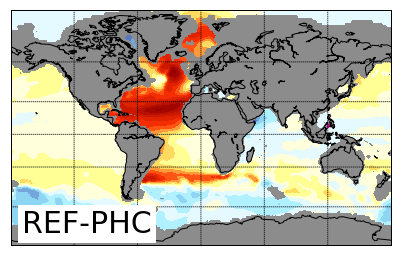

In [12]:
fig=plt.figure(figsize=(15,30))

plt.subplot(521)

#########################################################################################
#				   1000m   TEMPERATURE					#
#########################################################################################
# change it to get results on different layers.
nlevel = 18

# plot FESOM data, PHC data, and differences
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
x,y = m(xx,yy) # coordinates for target grid

#fig=plt.figure(figsize=(14,7))

#plt.subplot(122)
m.drawmapboundary(fill_color='0.55')
m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
m.fillcontinents(color='0.55')

levels = np.arange(-5., 5.5, 0.5)
plt.contourf(x, y, zz['REF']['temp_pot'][nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
plt.annotate(meshname4plots+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
#cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
#cbar.set_label("$^{\circ}$C", fontsize=32)
#plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
#plt.tight_layout()
plt.show()

## AGUV mesh + data

In [13]:
# config
meshname4plots ='HIGH1'
meshpath  ='/work/bm0944/input/aguv/' # AGUV at DKRZ

filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127aguv/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # AGUV at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127aguv/fesom.{}.oce.diag.nc' # AGUV at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

#firstyear=2016 # 30yr period at the beginning (year 9-38)
#lastyear=2045 
firstyear=2078 # 30yr period at the end (71--100)
lastyear=2107

# load data and compute density for above period
xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
# load and remap mixed layer for above period
#xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
#                                                                lastyear=lastyear, \
#                                                                mesh=mesh, \
#                                                                filetmp=filedia)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/aguv/joblib_mesh
Computing mean ...
Done.


In [14]:
zz['MR0']['temp_pot']=zz_temp_pot
zz['MR0']['zz_salt']=zz_salt
zz['MR0']['sigma_1']=zz_sigma_1

## GLOB mesh + data

In [15]:
# config
meshname4plots ='HIGH2'
meshpath  ='/work/ab0995/a270046/fesom-meshes/glob/' # GLOB at DKRZ

filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127glob/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # GLOB at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127glob/fesom.{}.oce.diag.nc' # GLOB at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

#firstyear=2016 # 30yr period at the beginning (year 9-38)
#lastyear=2045 
firstyear=2078 # 30yr period at the end (71--100)
lastyear=2107

# load data and compute density for above period
xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
# load and remap mixed layer for above period
#xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
#                                                                lastyear=lastyear, \
#                                                                mesh=mesh, \
#                                                                filetmp=filedia)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270046/fesom-meshes/glob/joblib_mesh
Computing mean ...
Done.


In [16]:
zz['MR']['temp_pot']=zz_temp_pot
zz['MR']['zz_salt']=zz_salt
zz['MR']['sigma_1']=zz_sigma_1

## BOLD mesh + data

In [17]:
# config
meshname4plots ='BOLD'
meshpath  ='/work/ab0995/a270067/fesom/bold/mesh_Agulhas/' # BOLD at DKRZ

filetmp = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127bold/cdo-postprocessing/fesom.{}.oce.annualmean.nc' # BOLD at DKRZ
filedia = '/work/ab0995/a270046/hierarchy-grids/cpl_output_T127bold/fesom.{}.oce.diag.nc' # BOLD at DKRZ

# load mesh
mesh = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=True, usepickle=False, usejoblib=True)

#firstyear=2016 # 30yr period at the beginning (year 9-38)
#lastyear=2045 
firstyear=2078 # 30yr period at the end (71--100)
lastyear=2107

# load data and compute density for above period
xx, yy, zz_temp_pot, zz_salt, clim, zz_sigma_1, PHC_sigma_1 = load_andcompute_TSRho_split(firstyear=firstyear, \
                                                                                    lastyear=lastyear, \
                                                                                    mesh=mesh, \
                                                                                    filetmp=filetmp )
# load and remap mixed layer for above period
#xx0, yy0, zz_MLDmean, zz_MLDmax, zz_MLDmin = load_andremap_MLD(firstyear=firstyear, \
#                                                                lastyear=lastyear, \
#                                                                mesh=mesh, \
#                                                                filetmp=filedia)

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270067/fesom/bold/mesh_Agulhas/joblib_mesh
Computing mean ...
Done.


In [18]:
zz['HR']['temp_pot']=zz_temp_pot
zz['HR']['zz_salt']=zz_salt
zz['HR']['sigma_1']=zz_sigma_1

## Plot everything in one figure

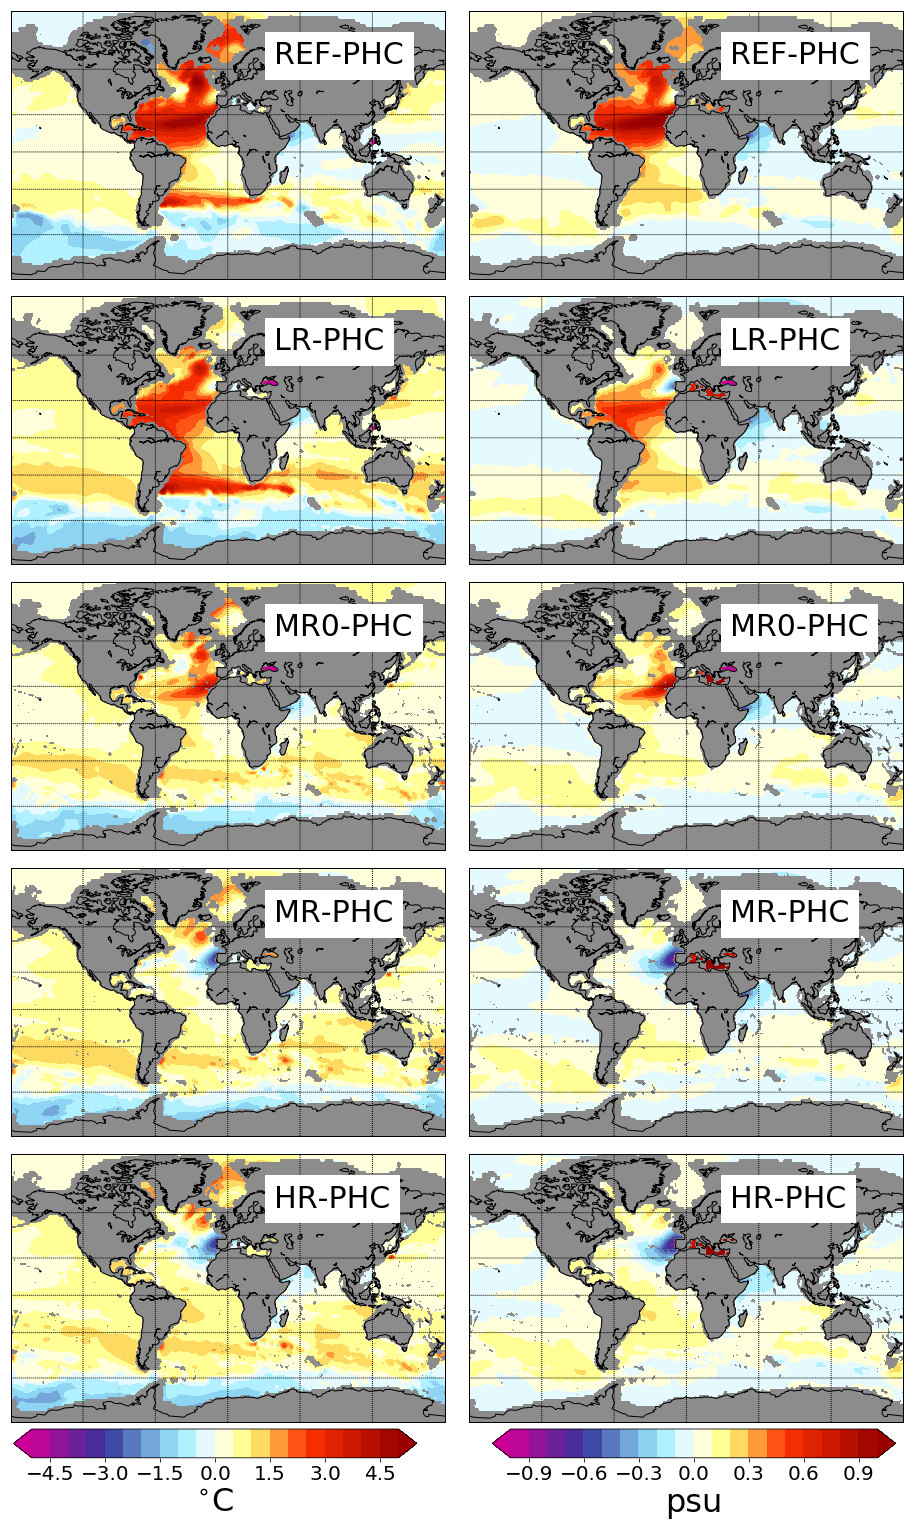

In [43]:
# change it to get results on different layers.
nlevel = 18 # 18: 1000m
    
def plotrow(axrow, temp, salt):
    #########################################################################################
    #				   1000m   TEMPERATURE					#
    #########################################################################################
    m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid

    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    levels = np.arange(-5., 5.5, 0.5)
    im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()
    
    
    #########################################################################################
    #				   1000m   SALINITY					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    levels = np.arange(-1., 1.1, 0.1)
    im2=axrow[1].contourf(x, y, salt[nlevel,:,]-clim.S[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    t=axrow[1].annotate(sim+'-PHC', xy=(-.45, 0.8), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    bb = t.get_bbox_patch()
    bb.set_boxstyle("square", pad=0.3)
    t2=axrow[1].annotate(sim+'-PHC', xy=(.6, 0.8), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    bb = t2.get_bbox_patch()
    bb.set_boxstyle("square", pad=0.3)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    return im1, im2
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 5
fig, axes = plt.subplots(nrows, 2, figsize=(14,20) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['REF','LR','MR0','MR','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2 = plotrow(row, zz[sim]['temp_pot'], zz[sim]['zz_salt'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.06, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.49+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, orientation = 'horizontal') 
cb1.set_label("$^{\circ}$C", fontsize=32) 
cb2.set_label("psu", fontsize=32) 
cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)

plt.tight_layout()    
plt.show()

In [45]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_1000m_tempsalt_minusPHC_split.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

In [19]:
zz['PHC']['temp_pot']=[]
zz['PHC']['zz_salt']=clim.S
zz['PHC']['sigma_1']=PHC_sigma_1

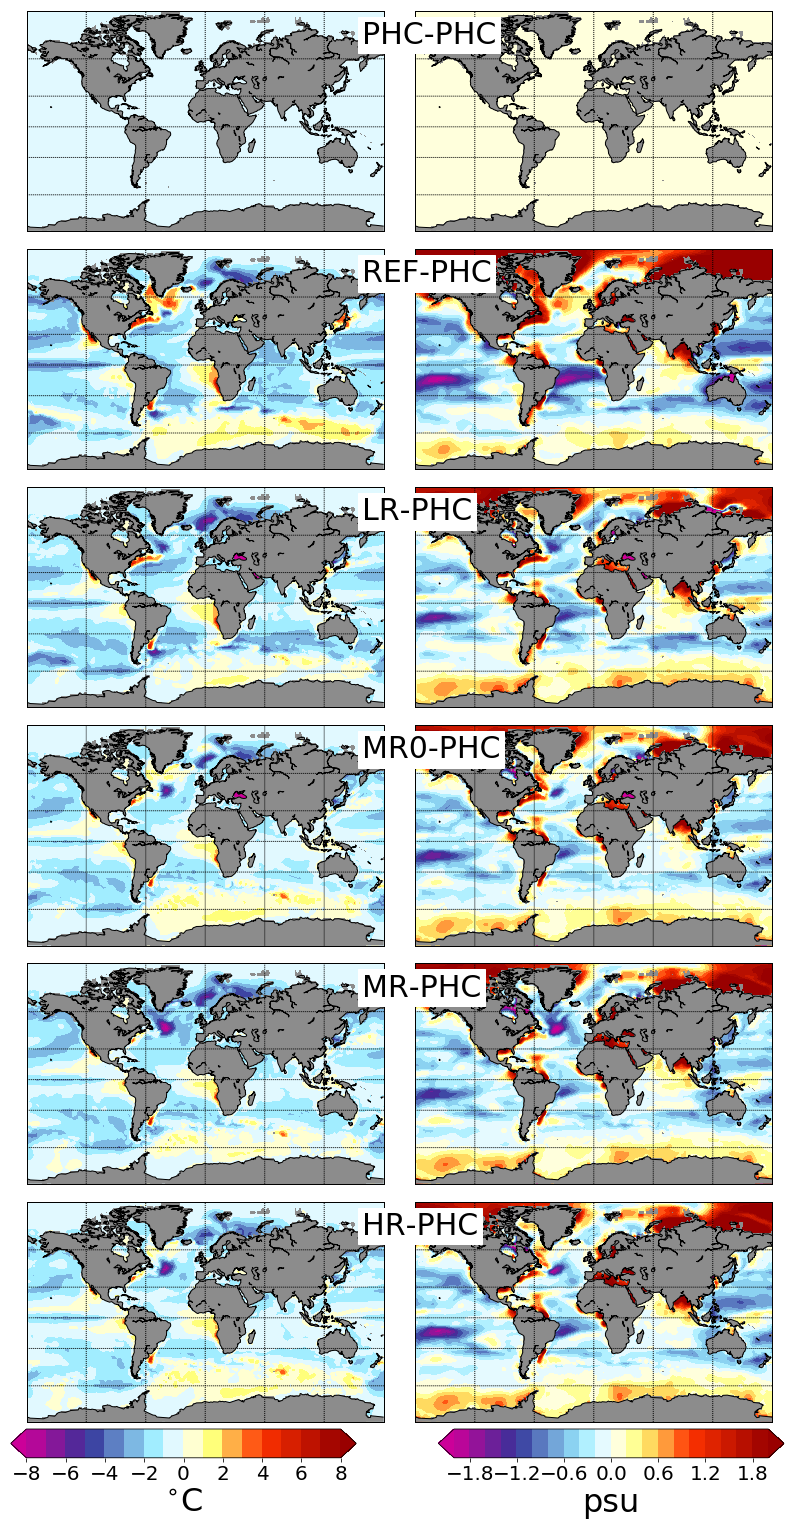

In [26]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, salt):
    #########################################################################################
    #				   SURFACE   TEMPERATURE					#
    #########################################################################################
    m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid

    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    levels = np.arange(-8., 8.0+1., 1.)
    im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()
    
    
    #########################################################################################
    #				   SURFACE   SALINITY					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=-80,urcrnrlat=85,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    levels = np.arange(-2., 2.2, 0.2)
    im2=axrow[1].contourf(x, y, salt[nlevel,:,]-clim.S[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim+'-PHC', xy=(-.15, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    return im1, im2
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 5
fig, axes = plt.subplots(nrows, 2, figsize=(12,20) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['REF','LR','MR0','MR','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2 = plotrow(row, zz[sim]['temp_pot'], zz[sim]['zz_salt'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.05, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, orientation = 'horizontal') 
cb1.set_label("$^{\circ}$C", fontsize=32) 
cb2.set_label("psu", fontsize=32) 
cb1.ax.tick_params(labelsize=20)
cb2.ax.tick_params(labelsize=20)

plt.tight_layout()    
plt.show()

In [26]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_0m_tempsalt_minusPHC.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


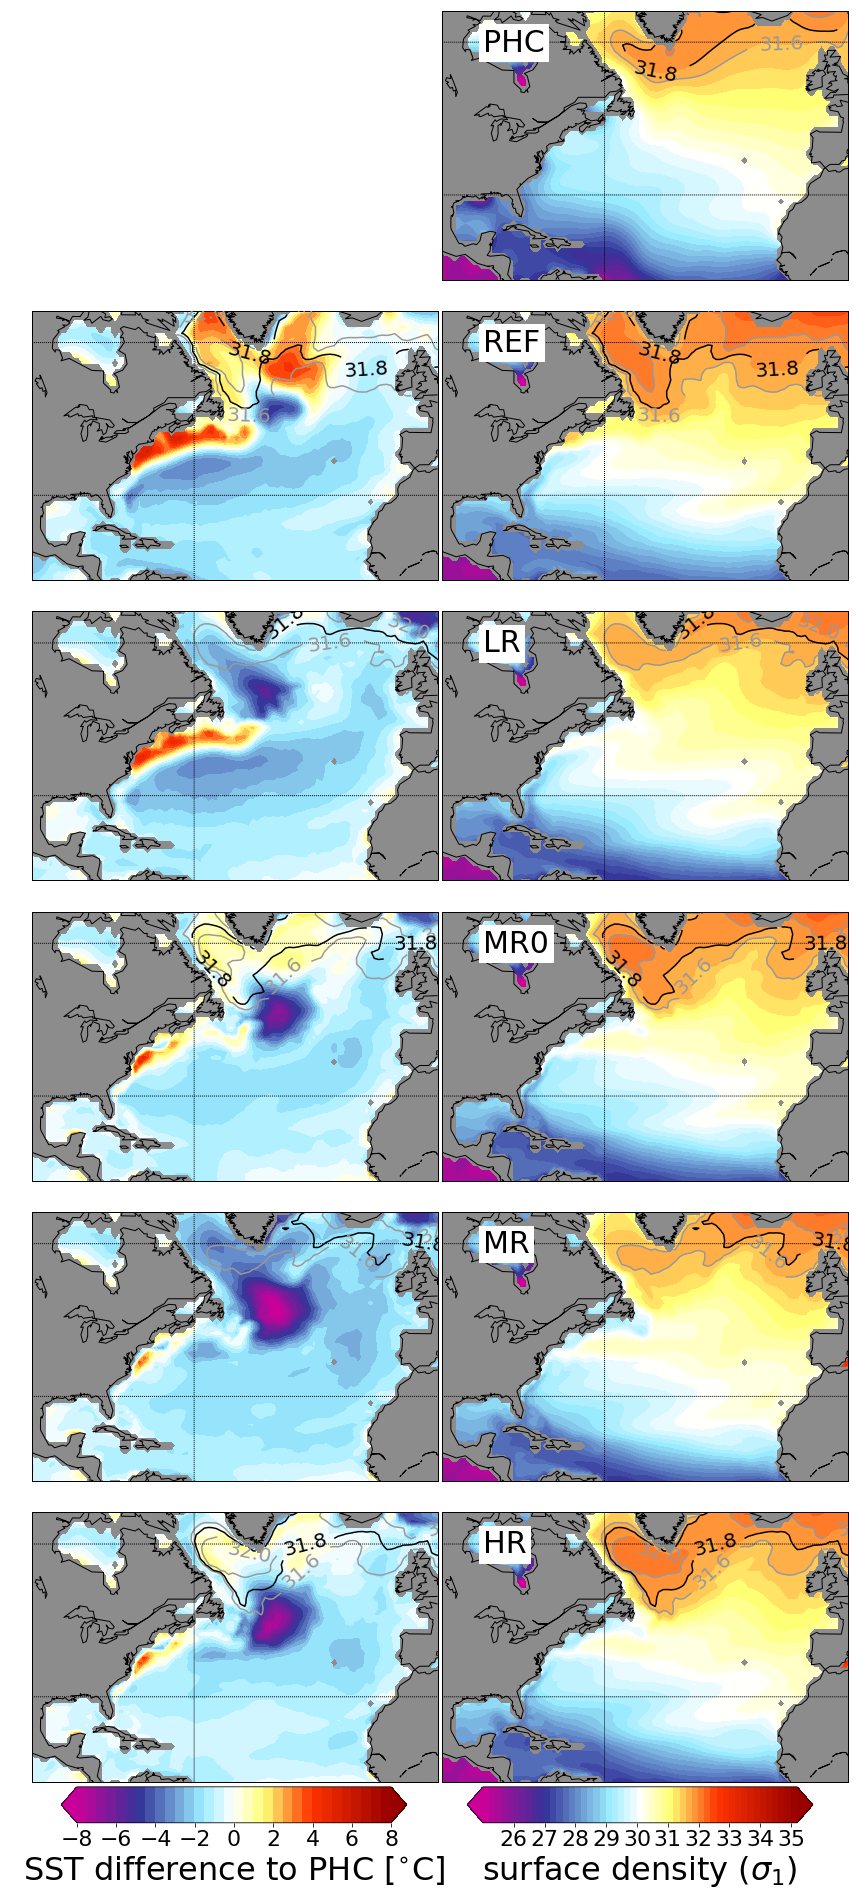

In [59]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 6
fig, axes = plt.subplots(nrows, 2, figsize=(12,25) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','LR','MR0','MR','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [60]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_ALL.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

In [ ]:
JAAA, REF MR0 und HR zeigen, MR und LR dann in dissucion??

Gleiches nochmal für Südozean. Dann Fig. austauschen gegen die beiden?

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


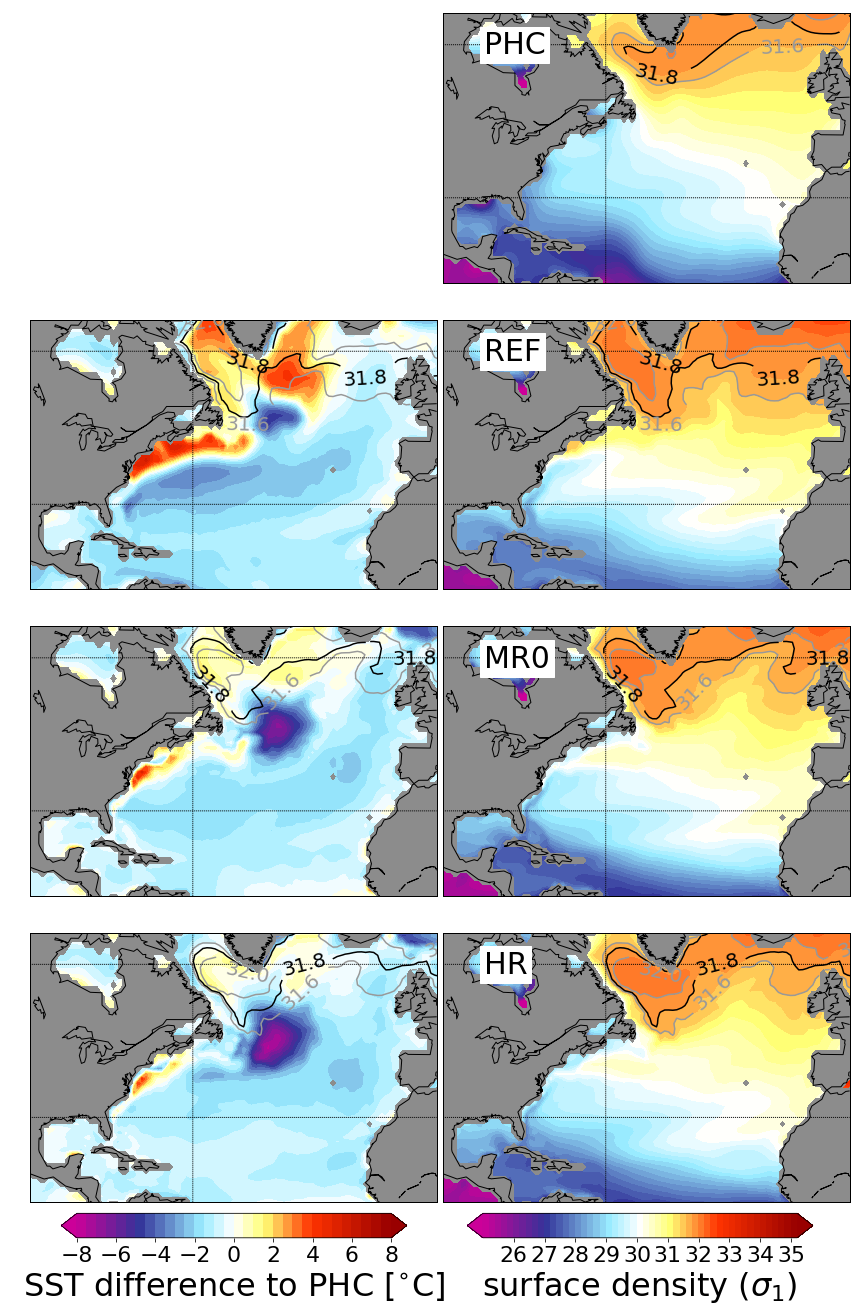

In [73]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 4
fig, axes = plt.subplots(nrows, 2, figsize=(12,17) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','MR0','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [ ]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_REFMR0HR.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


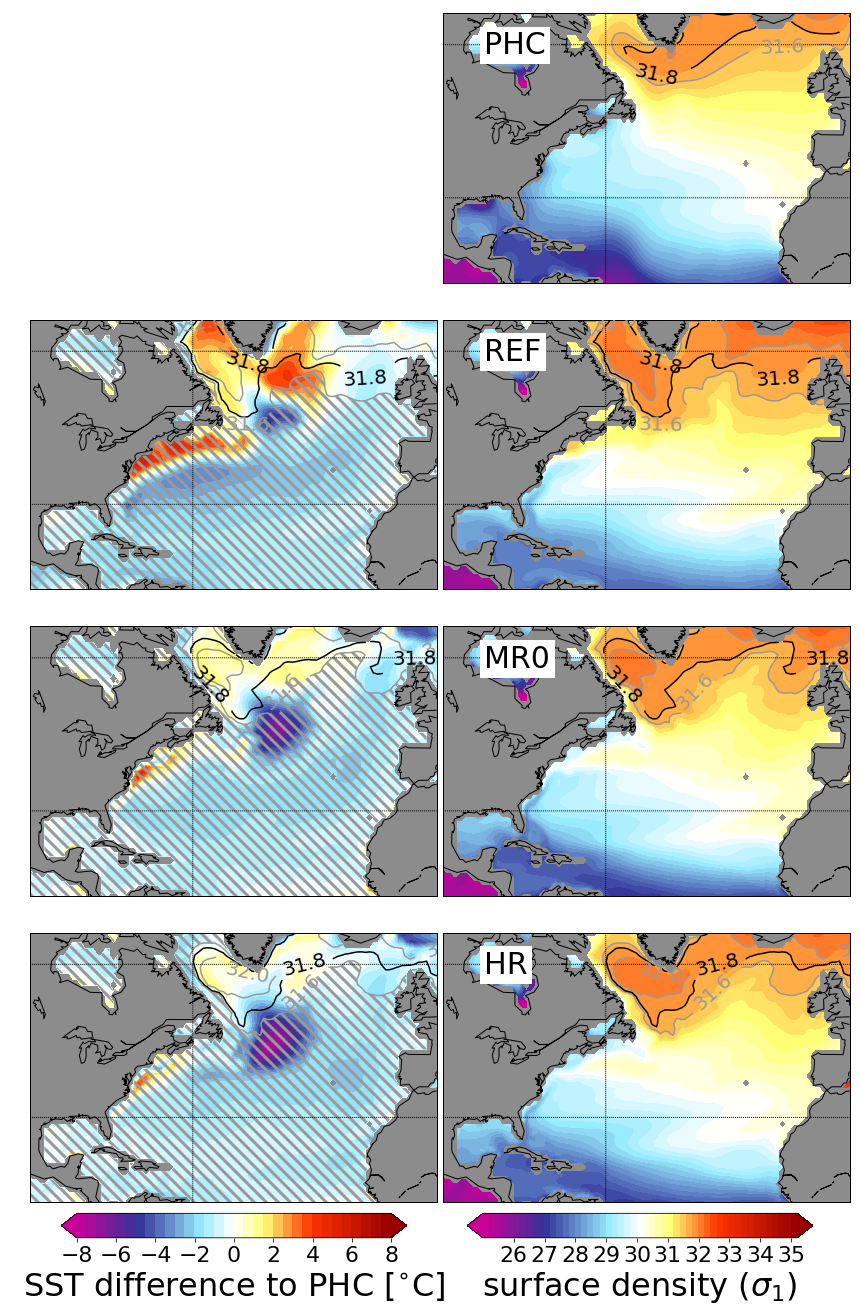

In [61]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   TEMP					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
        # hatching
        plt.rcParams['hatch.color'] = '0.6'
        plt.rcParams['hatch.linewidth'] = 3
        axrow[0].contourf(x, y, field[nlevel,:,], 2, colors='none',
                hatches=['\\\\', None, None], levels = im2.levels[[33,35]], \
                extend='both', zlev=0);
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 4
fig, axes = plt.subplots(nrows, 2, figsize=(12,17) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','MR0','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [62]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_REFMR0HR_hatching.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


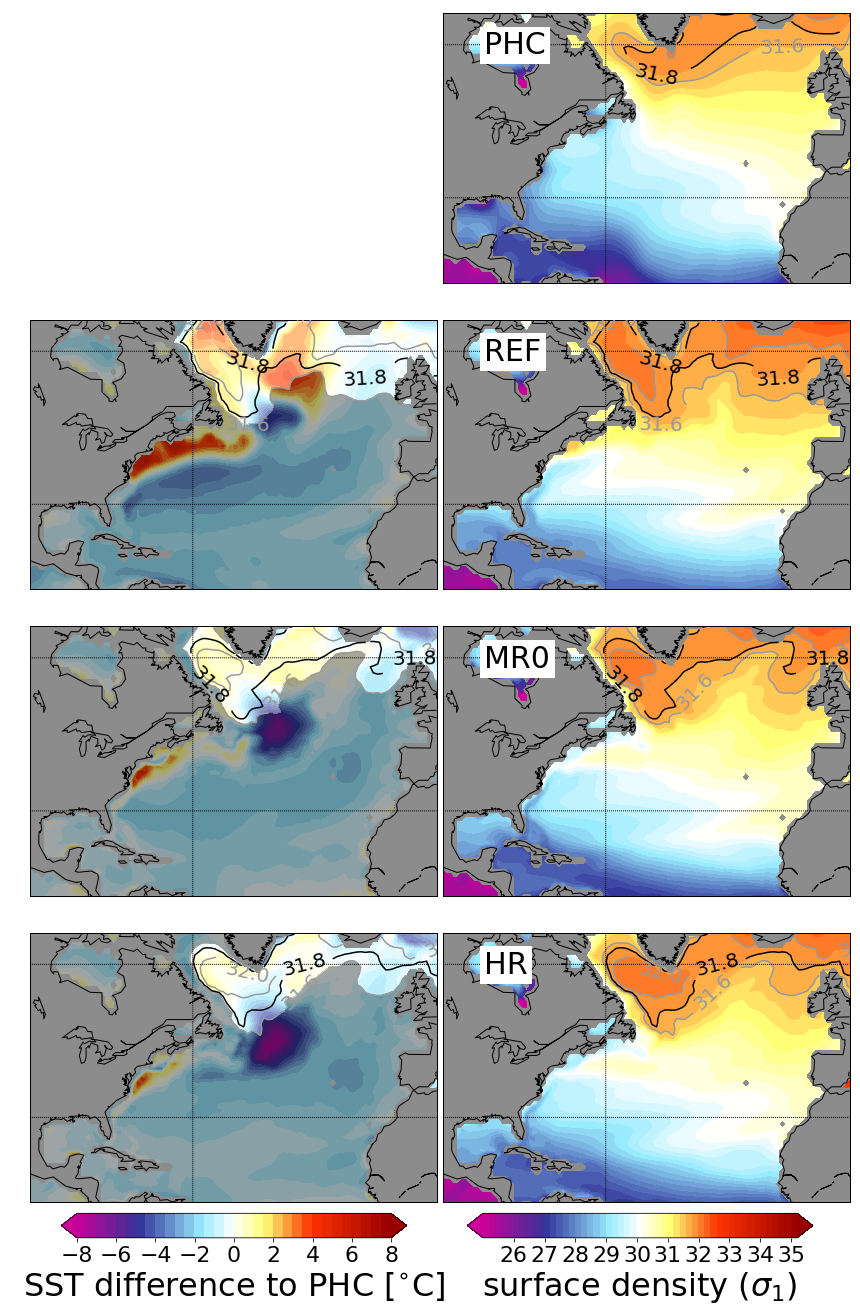

In [58]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   TEMP					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
        # hatching
        #plt.rcParams['hatch.color'] = '0.6'
        #axrow[0].contourf(x, y, field[nlevel,:,], 2, colors='none',
        #        hatches=['\\', None, None], levels = im2.levels[[33,35]], \
        #        extend='both', zlev=0);
        # transparency
        #axrow[0].contourf(x, y, field[nlevel,:,], 2, \
        #        colors=['gray', 'None', 'None'], alpha=.5, levels = im2.levels[[33,35]], \
        #        extend='both', zlev=0);
        axrow[0].contourf(x, y, field[nlevel,:,], 2, \
                colors=['black', 'white', 'white'], alpha=.35, levels = im2.levels[[33, 35]], \
                extend='both', zlev=80);
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 4
fig, axes = plt.subplots(nrows, 2, figsize=(12,17) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','MR0','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
#cb1.solids.set(alpha=.35)
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [44]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_REFMR0HR_transparency.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


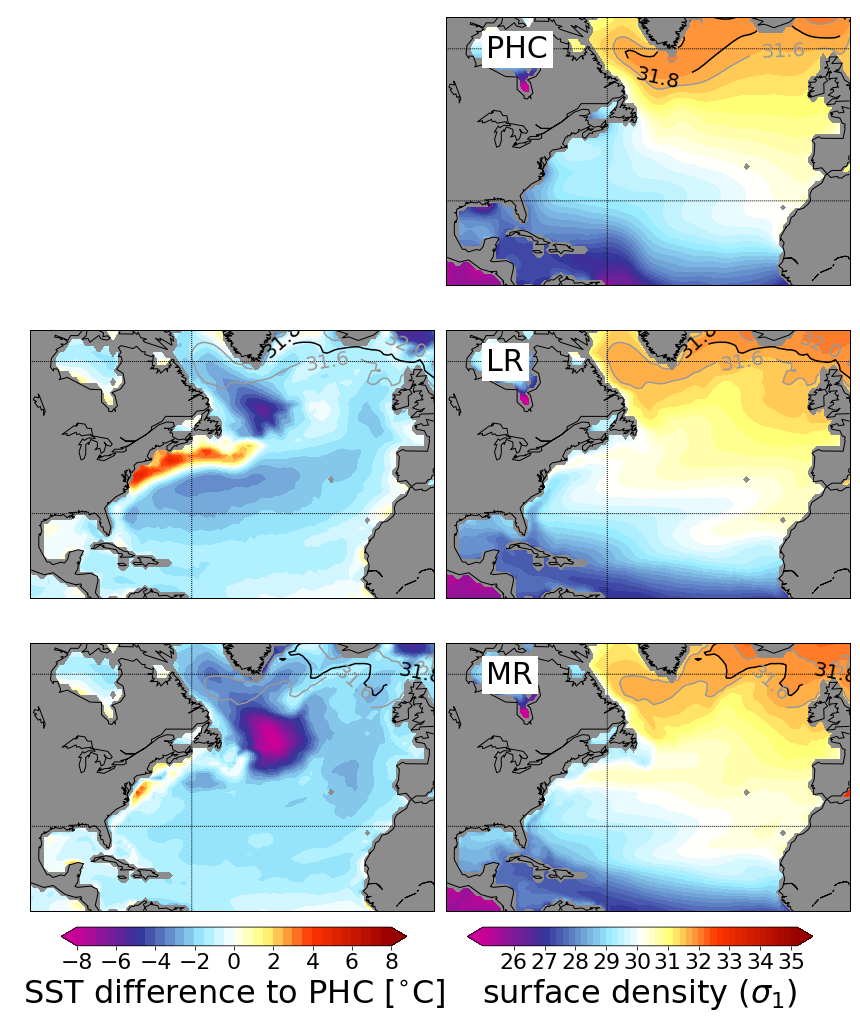

In [79]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 3
fig, axes = plt.subplots(nrows, 2, figsize=(12,13) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','LR','MR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [81]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_LRMR.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


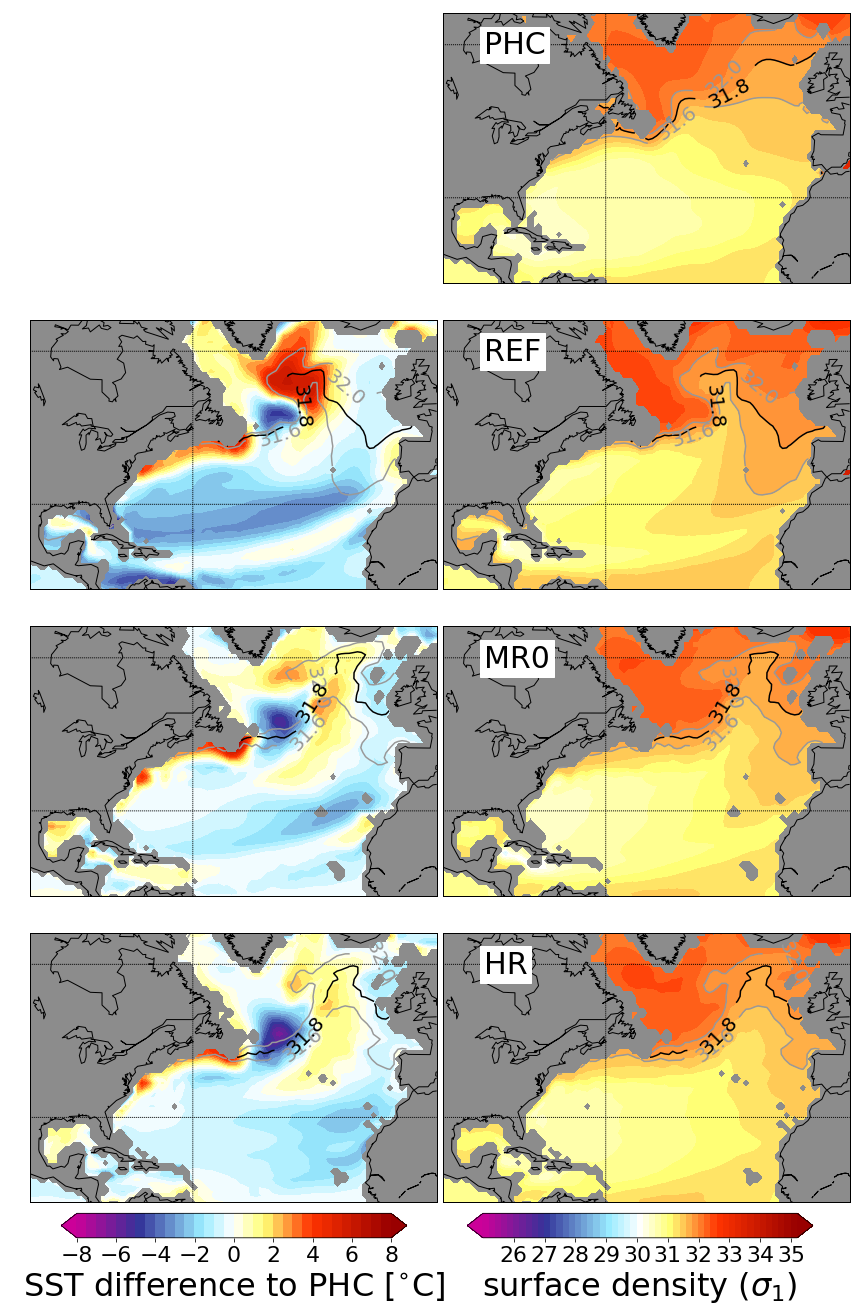

In [85]:
# change it to get results on different layers.
nlevel = 10 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=10,urcrnrlat=65,\
            llcrnrlon=-100,urcrnrlon=0,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 4
fig, axes = plt.subplots(nrows, 2, figsize=(12,17) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','MR0','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

### Southern Ocean

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


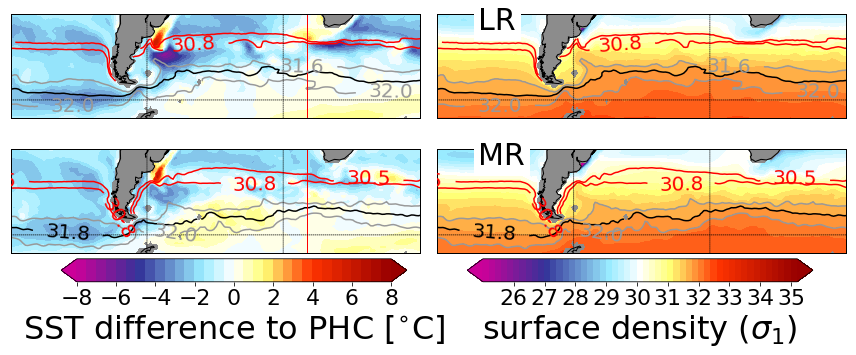

In [26]:
# change it to get results on different layers.
nlevel = 0 # 18: 1000m

latup=-30
latdown=-65
lonleft=-120
lonright=60
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=latdown,urcrnrlat=latup,\
                llcrnrlon=lonleft,urcrnrlon=lonright,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    levels = np.arange(25., 35.2, 0.1)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = levels[[55,58]], \
                        colors='red', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='red', fontsize=20)
    
    levels = np.arange(25., 35.2, 0.2)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp != []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=latdown,urcrnrlat=latup,\
                    llcrnrlon=lonleft,urcrnrlon=lonright,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-8., 8.0+0.5, .5)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        levels = np.arange(25., 35.2, 0.1)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = levels[[55,58]], \
                        colors='red', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='red', fontsize=20)
    
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
        
        # color the transect
        latline = [latdown, latup] 
        lonline = [10.5,10.5] 
        xline, yline = m(lonline, latline)
        m.plot(xline, yline, '-', markersize=5, linewidth=1, color='red') 
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 2
fig, axes = plt.subplots(nrows, 2, figsize=(12,4) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['LR','MR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.08]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.08]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label("SST difference to PHC [$^{\circ}$C]", fontsize=32) 
cb2.set_label("surface density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [27]:
# save the figure?
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/hierarchy_SSTminusPHC_sigma1_LRMR_SECTION.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()



## 4000m stuff that Sergey found

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


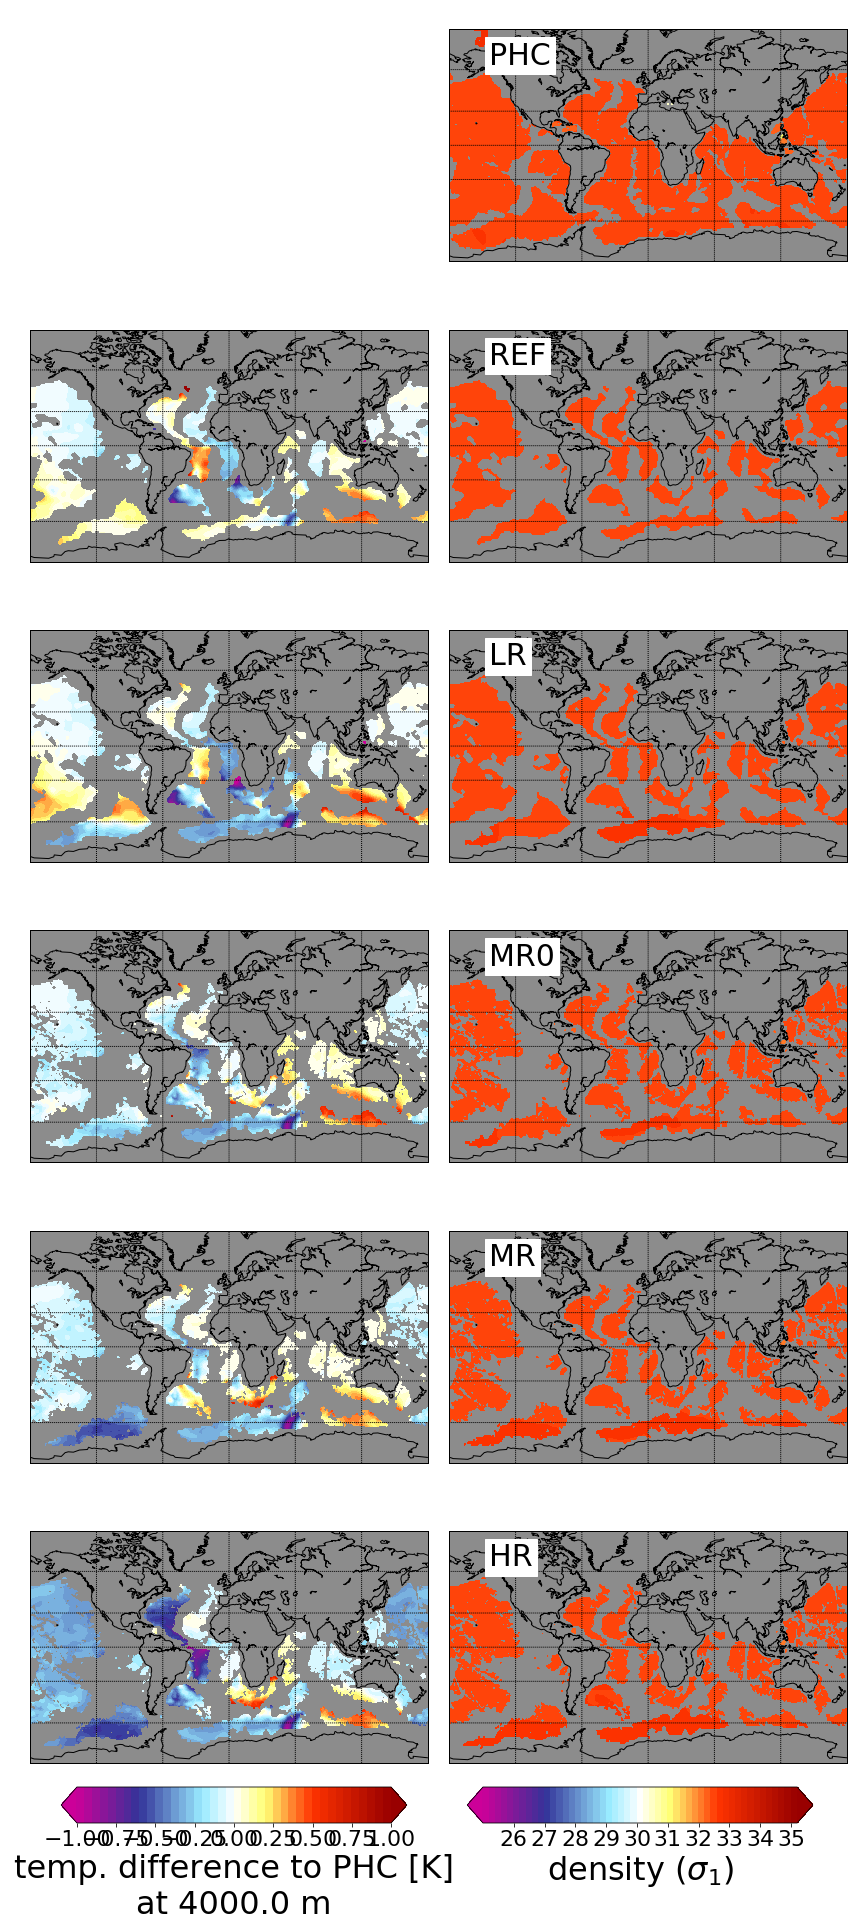

In [30]:
# change it to get results on different layers.
nlevel =29 #27: 3000 #29: 4000 # 18: 1000m
    
def plotrow(axrow, temp, field):
    
    #########################################################################################
    #				   SURFACE   SIGMA1					#
    #########################################################################################
    m = Basemap(ax=axrow[1],projection='mill',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
    x,y = m(xx,yy) # coordinates for target grid
    
    m.drawmapboundary(fill_color='0.55')
    m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
    m.fillcontinents(color='0.55')

    #levels = np.arange(-2., 2.2, 0.2)
    levels = np.arange(25., 35.2, 0.2)
    im2=axrow[1].contourf(x, y, field[nlevel,:,], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic, #-PHC_sigma_1[nlevel,:,:]
    
    #contours right
    CS=axrow[1].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
    CS=axrow[1].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
    plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
    
    #axrow[1].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    axrow[1].annotate(sim, xy=(0.1, 0.85), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
    #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
    #cbar.set_label("$^{\circ}$C", fontsize=32)
    #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
    #plt.tight_layout()  
    
    if temp !=  []:
        #########################################################################################
        #				   SURFACE   DENSITY					#
        #########################################################################################
        m = Basemap(ax=axrow[0],projection='mill',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

        m.drawmapboundary(fill_color='0.55')
        m.drawcoastlines(linewidth=1.0, linestyle='solid', color='black', antialiased=1)
        m.fillcontinents(color='0.55')

        levels = np.arange(-1., 1.0+0.05, .05)
        im1=axrow[0].contourf(x, y, temp[nlevel,:,]-clim.T[nlevel,:,:], levels = levels, \
                cmap=cmap_correlations256, extend='both', zlev=0); # cm.seismic
        #axrow[0].annotate(sim+'-PHC', xy=(0.029, 0.055), xycoords='axes fraction', backgroundcolor = 'white', color='k', fontsize=30)
    
        #contours left
        CS=axrow[0].contour(x, y, field[nlevel,:,], 2, levels = im2.levels[[33,35]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='0.6', fontsize=20)
        CS=axrow[0].contour(x, y, field[nlevel,:,], 1, levels = im2.levels[[34]], \
                        colors='0.6', extend='both', zlev=0);
        plt.clabel(CS, fmt='%2.1f', inline=True, colors='k', fontsize=20)
    
        m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
        m.drawmeridians(np.arange(-120,120+60,60),labels=[0,0,0,0])
        #cbar=plt.colorbar(orientation = 'horizontal', pad=0.03)
        #cbar.set_label("$^{\circ}$C", fontsize=32)
        #plt.title('FESOM-PHC, {} m.'.format(str(clim.z[nlevel])));
        #plt.tight_layout()
    else:
        axrow[0].axis('off')
        im1=[]
    
    return im1, im2, CS
    
    
# plot FESOM data, PHC data, and differences
#m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=85,\
#            llcrnrlon=-180,urcrnrlon=180,resolution='c')


nrows = 6
fig, axes = plt.subplots(nrows, 2, figsize=(12,25) ) #sharey=True, sharex=True
plt.subplots_adjust(wspace = .001)
i=0

sims=['PHC','REF','LR','MR0','MR','HR']

for row in axes:
    
    sim=sims[i]
    im1, im2, CS = plotrow(row, zz[sim]['temp_pot'], zz[sim]['sigma_1'])
    i=i+1
  
# Now adding the colorbar
cbaxes1 = fig.add_axes([0.075, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cbaxes2 = fig.add_axes([0.5+0.045, -0.015, 0.4, 0.02]) # x pos, y pos, x length, y length
cb1 = fig.colorbar(im1, cax = cbaxes1, orientation = 'horizontal') 
cb2 = fig.colorbar(im2, cax = cbaxes2, ticks=np.arange(26., 36., 1.), orientation = 'horizontal') 
cb1.set_label('temp. difference to PHC [K]\n'+'at {} m'.format(str(clim.z[nlevel])), fontsize=32) 
cb2.set_label("density ($\sigma_1$)", fontsize=32) 
cb1.ax.tick_params(labelsize=22)
cb2.ax.tick_params(labelsize=22)

plt.tight_layout()    
plt.show()

In [ ]:
do this with Southern Ocean in the picture, beginning and end to see evolution over time.